# Covariate Analysis

## Cleaning the Data

A brief analysis to determine which covariates can be:
- Reasonably dropped.
- Aggregated or combined in dimensionality reduction.
- 
- Determine the expected functional form of each covariate (linear, squared, cubed, piecewise etc).


### Notable Tables

The fundamental tables utilized in the analysis

- `spf.ed.summary_table`: summary data for each participant (aggregated performance over each task)
- `spf.wcst_performance`: wcst raw data


Key Attributes:

- `spf.ed.summary_table`
    - participant id _(primary key)_
    - demographic statistics
    - cognitive statistics

- `spf.wcst_performance`:
    - participant id _(foriegn key)_
    - wcst performance bins
    - wcst score


-----

plots to update:
- wcst_performance_plot


---------
```
Zach Wolpe
zachcolinwolpe@gmail.com
07 Sep 2021
```
---------

In [17]:
from typing import Text
from pandas.io.formats import style
import seaborn as sns
from dash_core_components.Dropdown import Dropdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import re
import sys
sys.path.append('../process data/')
import scipy.stats as stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.offline as pyo
import plotly.express as px
from encode_processed_data import encode_data

import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
import plotly.graph_objects as go
from dash.dependencies import Input, Output

from summary_plots_and_figures import summary_plots_and_figures

In [24]:
# ---- fetch data object ----x
with open('../data objects/batch_processing_object_with_encodings.pkl', 'rb') as file2:
    ed = pd.read_pickle(file2)

# ---- instantiate subclass: spf ----x
spf = summary_plots_and_figures(ed)
spf.available_data()


        ---- New Tables ------------------------------------------------------------------------------*

            final_data_aggregated               : all data (grouped over wcst performance groups)
            final_data_unaggregated             : all data

        ---- Metadata --------------------------------------------------------------------------------*
            
            continuous_vars                     : continuous vars available
            categorical_vars                    : categorical vars available
            demographic_groups                  : categorical demographics data
            demographic_cont_vars               : continuous demographics data
            demo_pie_map                        : demographics pie chart
            demo_continuous_naming              : demographics continuous names
        
        ---- Methods ---------------------------------------------------------------------------------*

            create_performance_groupings

# Outlier Handling 

The final stage of cleaning the data is to handle outliers, constituting 4 steps:
1. `Outlier Definition` - what values are considered outliers
2. `Outlier Detection`  - identification of said values
3. `Outlier Removal`    - removal of samples where necessary 
4. `Outlier Imputation` - imputation of data where necessary


A number of strategies could be employed when handling outliers:

1. `removal`                - drop incomplete samples
2. `mean imputation`        - add a placeholder value that represents the mean value (if continuous) or an additional category (if categorical)
3. `forecast imputation`    - model the missing data as a function of the available data, at the risk of overfitting


Two tables carry the information that require handling outliers:
- `spf.`

In [52]:
# data to handle outliers
summary_table   = spf.ed.summary_table.copy()
wcst_data       = spf.ed.raw.wcst_data.copy()

# summary_table


#  # ----- wcst ----x
#         def compute_performance_trial_bins(n_bins=10, wcst_data=ed.raw.wcst_data):
#             """Return: DataFrame capturing the performance per n_bins triasl"""

#             # ---- add trial number ----x
#             xx = []; df = wcst_data
#             [xx.append((i%100)+1) for i in range(df.shape[0])]
#             df['trial_no'] = xx 

#             # ---- status==1 --> correct
#             t = np.linspace(0,100,num=n_bins+1).tolist(); c=0

#             for tt in t[1:]:
#                 c +=1
#                 x = df.loc[df['trial_no'] < tt,].groupby(['participant', 'status']).agg({
#                 'participant':              ['count'],
#                 'reaction_time_ms':         ['mean', 'std'],
#                 'perseverance_error':       ['mean'],
#                 'not_perseverance_error':   ['mean']
#                 }).reset_index()
#                 x['percentages'] = x[('participant', 'count')]/tt
#                 x['trials']      = str(round(t[c-1])) + '-' + str(round(t[c]))
#                 x['trials_2']    = t[c]
#                 if c==1:    data=x
#                 else:       data=data.append(other=x)

#             # if x>0 --> perseverance_error > not_perseverance_error --> main error=perseverance_error
#             data['main_error'] = np.where(data['perseverance_error'] - data['not_perseverance_error'] > 0, 'perserverance errors', 'non perserverance errors')

#             return(data)

#         x = compute_performance_trial_bins(n_bins=1)
#         x = x.loc[x['status']==1, [('participant', ''), ('reaction_time_ms', 'mean'), ('percentages', '')]].set_index('participant')
#         x.columns = ['wcst_RT', 'wcst_accuracy']
#         wcst = x


# Index(['participant', 'participant_code', 'card_no', 'correct_card',
#        'correct_persevering', 'seq_no', 'rule', 'card_shape', 'card_number',
#        'card_colour', 'reaction_time_ms', 'status', 'card_selected', 'error',
#        'perseverance_error', 'not_perseverance_error', 'trial_no'],
#       dtype='object')


wcst_data       = spf.ed.raw.wcst_data.copy()
wcst_data['correct'] = wcst_data.status==1

wcst = wcst_data.groupby('participant').agg({
    'correct': 'mean',
    'reaction_time_ms': 'mean'
})

wcst.columns = ['wcst_accuracy', 'wcst_RT']
wcst

,wcst_accuracy,wcst_RT
participant,,
100934.0,0.84,1795.16
103322.0,0.87,1406.27
107700.0,0.83,1415.35
117200.0,0.79,1154.50
117306.0,0.83,2044.93
120307.0,0.69,1625.70
122240.0,0.83,2023.51
127180.0,0.51,4120.81
130202.0,0.80,1637.83


In [16]:

# ---- performance groupings ----x 
spf.create_performance_groupings(3)

    # # spf.compute_wcst_performance_trial_bins(n_bins=10, use_seq=None, g=1)

for i in [1, 3, 5, 15]:
    spf.compute_wcst_performance_trial_bins(i)
    # spf.compute_wcst_performance_trial_bins(1)
    # spf.final_data_aggregated
    # # spf.random_participants_sample(10)

    # # spf.final_data_unaggregated.head()
    # # spf.wcst_performance.head()
    # # spf.final_data_aggregated.head()

    spf.wcst_performance_plot()['figure'].show()
    print(spf.wcst_performance_plot()['data'].head())

  corsi_group  trail_groups_numeric_wcst  reaction_time_ms_mean_wcst  \
0     0.0-4.5                       19.0                 2377.385799   
1     0.0-4.5                       27.0                 2095.604953   
2     0.0-4.5                       35.0                 1604.654481   
3     0.0-4.5                       42.0                 1895.125337   
4     0.0-4.5                       47.0                 2078.733962   

   correct_wcst  
0      0.638530  
1      0.580189  
2      0.872642  
3      0.591644  
4      0.464151  


  corsi_group  trail_groups_numeric_wcst  reaction_time_ms_mean_wcst  \
0     0.0-4.5                       47.0                 2094.296869   
1     0.0-4.5                       65.0                 1683.996855   
2     0.0-4.5                       83.0                 1646.171908   
3     0.0-4.5                      100.0                 1481.777469   
4     4.5-9.0                       47.0                 1798.862448   

   correct_wcst  
0      0.642914  
1      0.680818  
2      0.696017  
3      0.907325  
4      0.740757  


  corsi_group  trail_groups_numeric_wcst  reaction_time_ms_mean_wcst  \
0     0.0-4.5                       70.0                 1950.059973   
1     0.0-4.5                      100.0                 1568.700314   
2     4.5-9.0                       70.0                 1717.426456   
3     4.5-9.0                      100.0                 1397.805541   
4          Na                       70.0                 2487.116819   

   correct_wcst  
0      0.670081  
1      0.783962  
2      0.760408  
3      0.841905  
4      0.566685  


Empty DataFrame
Columns: [corsi_group, trail_groups_numeric_wcst, reaction_time_ms_mean_wcst, correct_wcst]
Index: []


,trail_groups_wcst,trail_groups_numeric_wcst,correct_wcst,reaction_time_ms_mean_wcst,reaction_time_ms_std_wcst,perseverance_error_wcst,not_perseverance_error_wcst,main_wcst,nback_status,nback_reaction_time_ms,...,demographics_income_a,demographics_computer_hours_a,demographics_age_group,demographics_mean_reation_time_ms,nback_group,fitts_group,corsi_group,navon_group,wcst_group,random_participants
participant,,,,,,,,,,,,,,,,,,,,,
100934.0,0-47,47.0,0.872340,2036.531915,1224.007563,0.0,0.127660,non perserverance errors,0.894444,2218.077778,...,7.0,25.0,25-34,11453.571429,0.84-0.92,-137.21-43.7,3.0-4.0,0.11-0.22,0.81-0.9,other
100934.0,0-47,47.0,0.872340,2036.531915,1224.007563,0.0,0.127660,non perserverance errors,0.894444,2218.077778,...,7.0,25.0,25-34,11453.571429,0.84-0.92,-137.21-43.7,3.0-4.0,0.44-0.56,0.81-0.9,other
100934.0,0-47,47.0,0.872340,2036.531915,1224.007563,0.0,0.127660,non perserverance errors,0.894444,2218.077778,...,7.0,25.0,25-34,11453.571429,0.84-0.92,-137.21-43.7,3.0-4.0,0.44-0.56,0.81-0.9,other
100934.0,47-65,65.0,0.722222,2346.833333,2220.148385,0.0,0.277778,non perserverance errors,0.894444,2218.077778,...,7.0,25.0,25-34,11453.571429,0.84-0.92,-137.21-43.7,3.0-4.0,0.11-0.22,0.81-0.9,other
100934.0,47-65,65.0,0.722222,2346.833333,2220.148385,0.0,0.277778,non perserverance errors,0.894444,2218.077778,...,7.0,25.0,25-34,11453.571429,0.84-0.92,-137.21-43.7,3.0-4.0,0.44-0.56,0.81-0.9,other


In [1]:








# def wcst_performance_plot(
# self, 
group='fitts_group' # nback_group	fitts_group	corsi_group	navon_group	wcst_group
mean_plot=True
colours=sum([px.colors.sequential.Plasma*3], [])
title='WCST Performance'
xaxis={'title':'trials'}
yaxis={'title':'% Correct'}
template='none'
legend_title_text=''
width=1000
height=500
show_vlines=False 
# ):

data = spf.final_data_aggregated.copy()





    #     # # ---- reset column names ----x
    #     cols = []
    #     for c in data.columns:
    #             if type(c) is tuple: cols.append('_'.join(c).strip('_'))
    #             else: cols.append(c)
    #     data.columns = cols
        
def compute_performance_per_group(data, group):
    return data.groupby([group, 'trail_groups_numeric_wcst']).agg({
        'reaction_time_ms_mean_wcst': 'mean',
        'correct_wcst': 'mean'}).reset_index()
if not group:
    None
        # data['all'] = 'all data' 
        # group = 'all'
data = compute_performance_per_group(data=data, group=group)


# ---------- plots ----------x
if not legend_title_text: legend_title_text = group
groups = data[group].unique()
traces = []
c=-1


# percentages ---> correct_wcst
# trials_2    ---> trail_groups_numeric_wcst
# reaction_time_ms_mean ---> reaction_time_ms_mean_wcst
groups
for g in groups:
    c+=1
    if g != 'Na' and g != 'other':
        # df    = data.loc[(data[group] == g), ['trials_2', 'correct_wcst', 'reaction_time_ms_mean']]
        df    = data.loc[(data[group] == g), ['trail_groups_numeric_wcst', 'correct_wcst', 'reaction_time_ms_mean_wcst']].drop_duplicates()
        trace = go.Scatter(x=df.trail_groups_numeric_wcst, y=df.correct_wcst, mode='lines+markers', name='{}'.format(g),
                line=dict(color='black'), 
                marker=dict(
                    size=df['reaction_time_ms_mean_wcst']/100,
                    color=colours[c],
                    opacity=0.75,
                    line=dict(color='white'))
                    )
        traces.append(trace)
        
if mean_plot:
    df = data.groupby('trail_groups_numeric_wcst').agg({
        'correct_wcst'               :'mean', 
        'reaction_time_ms_mean_wcst' :'mean'
        }).reset_index()
    g  = 'aggregate'
    trace = go.Scatter(x=df.trail_groups_numeric_wcst, y=df['correct_wcst'], mode='lines+markers', name='{}'.format(g),
            line=dict(color='black'), 
            marker=dict(
                size=df['reaction_time_ms_mean_wcst']/100,
                color=colours[-1],
                opacity=0.75,
                line=dict(color='white'))
                )
    traces.append(trace)

layout  = go.Layout(title=title, xaxis=xaxis, yaxis=yaxis, template=template, legend_title_text=legend_title_text, width=width, height=height)
fig     = go.Figure(data=traces, layout=layout)

if True:
    cum_seq=[10,19,27,35,42,47,53,60,65,70,77,83,88,94,100]
    for c in cum_seq: fig.add_vline(x=c, line_width=0.75, line_dash='dash', line_color='steelblue')
        # return {'figure': fig, 'data':data}
    
fig.show()


NameError: name 'px' is not defined

In [2]:
data = spf.final_data_aggregated.copy()

# data.loc[(data[group] == g), ['trail_groups_numeric_wcst', 'correct_wcst', 'reaction_time_ms_mean_wcst']]



NameError: name 'spf' is not defined

In [8]:
# ===== TEST: 
# def compute_wcst_performance_trial_bins(self, n_bins=10, use_seq=None, g=1):
#     """
#     compute WCST performance bins
    
#     Return: DataFrame capturing the performance per n_bins trials"""
#     wcst_data=self.ed.raw.wcst_data

#     # ---- add trial number ----x
#     xx = []; df = wcst_data
#     [xx.append((i%100)+1) for i in range(df.shape[0])]
#     df['trial_no'] = xx 

#     # ---- status==1 --> correct
#     t = np.linspace(0,100,num=n_bins+1).tolist(); c=0

#     #--- if SEQ is true ---x
#     seq=[10, 9, 8, 8, 7, 5, 6, 7, 5, 5, 7, 6, 5, 6]
#     def return_breakpoints(g=1, options=[1,2,3,4,5], cum_seq=[10,19,27,35,42,47,53,60,65,70,77,83,88,94,100]):
#         def grps(grp): return [i // grp for i in range(len(cum_seq))]
#         breakpoints = [0]
#         xx=grps(g)
#         for i in range(1,len(xx)):
#             if    (xx[i]!=xx[i-1]) & (i!=(len(xx)-1)):  breakpoints.append(i-1) 
#             if    i==(len(xx)-1):                       breakpoints.append(i)
#         return list(map(cum_seq.__getitem__, breakpoints))
#     if use_seq is not None: 
#         t=return_breakpoints(g)
#         t[:0] = [0]

#     for tt in t[1:]:
#         c +=1
#         x = df.loc[df['trial_no'] < tt,].groupby(['participant', 'status']).agg({
#         'participant':              ['count'],
#         'reaction_time_ms':         ['mean', 'std'],
#         'perseverance_error':       ['mean'],
#         'not_perseverance_error':   ['mean']
#         }).reset_index()
#         x['percentages'] = x[('participant', 'count')]/tt
#         x['trials']      = str(round(t[c-1])) + '-' + str(round(t[c]))
#         x['trials_2']    = t[c]
#         if c==1:    data=x
#         else:       data=data.append(other=x)

#     # if x>0 --> perseverance_error > not_perseverance_error --> main error=perseverance_error
#     data['main_error'] = np.where(data['perseverance_error'] - data['not_perseverance_error'] > 0, 'perserverance errors', 'non perserverance errors')
#     self.wcst_performance = data



# -------- parameters
n_bins=10
g=1
use_seq=True

# (dcc.Slider(id='wcst_groups', min=1, max=10, step=1, value=1))
# nbins=10, use_seq=True, g=wcst_groups)

# ===== Assuming no groups =====x

wcst_data=spf.ed.raw.wcst_data.copy()
wcst_data.head()

# ---- add trial number ----x
xx = []; df = wcst_data
[xx.append((i%100)+1) for i in range(df.shape[0])]
df['trial_no'] = xx 


# ---- status==1 --> correct
t = np.linspace(0,100,num=n_bins+1).tolist(); c=0



for g in [1,2,3,4,5]:


    #--- if SEQ is true ---x
    seq=[10, 9, 8, 8, 7, 5, 6, 7, 5, 5, 7, 6, 5, 6]
    def return_breakpoints(g=1, options=[1,2,3,4,5], cum_seq=[10,19,27,35,42,47,53,60,65,70,77,83,88,94,100]):
        def grps(grp): return [i // grp for i in range(len(cum_seq))]
        breakpoints = [0]
        xx=grps(g)
        print('xx: ', xx)
        for i in range(1,len(xx)):
            if    (xx[i]!=xx[i-1]) & (i!=(len(xx)-1)):  breakpoints.append(i-1) 
            if    i==(len(xx)-1):                       breakpoints.append(i)
        return list(map(cum_seq.__getitem__, breakpoints))
    if use_seq is not None: 
        t=return_breakpoints(g)
        t[:0] = [0]
        

    print('g: ', g, ' t: ', t)
    print('-------')


for tt in t[1:]:
    # print('tt: ', tt)
    c +=1
#     x = df.loc[df['trial_no'] < tt,].groupby(['participant', 'status']).agg({
#     'participant':              ['count'],
#     'reaction_time_ms':         ['mean', 'std'],
#     'perseverance_error':       ['mean'],
#     'not_perseverance_error':   ['mean']
#     }).reset_index()

    
#     x['percentages'] = x[('participant', 'count')]/tt
#     x['trials']      = str(round(t[c-1])) + '-' + str(round(t[c]))
#     x['trials_2']    = t[c]
#     if c==1:    data=x
#     else:       data=data.append(other=x)


    
# # x.loc[x[('participant','')]==100934.0,:]
# data.loc[data[('participant','')]==100934.0,:]



xx:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
g:  1  t:  [0, 10, 10, 19, 27, 35, 42, 47, 53, 60, 65, 70, 77, 83, 88, 100]
-------
xx:  [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7]
g:  2  t:  [0, 10, 19, 35, 47, 60, 70, 83, 100]
-------
xx:  [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]
g:  3  t:  [0, 10, 27, 47, 65, 83, 100]
-------
xx:  [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3]
g:  4  t:  [0, 10, 35, 60, 83, 100]
-------
xx:  [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
g:  5  t:  [0, 10, 42, 70, 100]
-------


In [9]:
# ---- wcst data ----*
wcst_data=spf.ed.raw.wcst_data.copy()

# ---- add trial number ----*
xx = []; df = wcst_data
[xx.append((i%100)+1) for i in range(df.shape[0])]
df['trial_no'] = xx 

# ---- split into n groups -----*
options = [1,3,5,15]; 
o=3 # select o per group
cum_sum = [10,19,27,35,42,47,53,60,65,70,77,83,88,94,100]
groups = [i//o for i in range(15)]

# ---- identify unique groups ----*
breakpoints = []
for t in range(1, len(groups[1:])+1):
    if groups[t] != groups[t-1] and t!=len(groups[1:]): breakpoints.append(cum_sum[t-1])
    elif t==len(groups[1:]):                            breakpoints.append(cum_sum[t])
breakpoints[0] = 0

# ----- create bins ----*
wcst_bins          = []
df['trail_groups'] = np.nan
df['correct']      = df['status'] == 1
for b in range(1, len(breakpoints)): 
    B   = breakpoints[b]
    B_1 = breakpoints[b-1]
    grp = str(B_1) + '-' + str(B)
    wcst_bins.append(grp)
    df.loc[(df['trial_no'] > B_1) & (df['trial_no'] <= B), 'trail_groups'] = grp



# ---- compute aggregate statistics ----*
df.groupby(['participant', 'trail_groups']).agg({
    'participant':              ['count'],
    'correct':                  ['mean'],
    'reaction_time_ms':         ['mean', 'std'],
    'perseverance_error':       ['mean'],
    'not_perseverance_error':   ['mean']

})

self.wcst_performance = data
# ----- test ----x
print('groups:      ', groups)
print('cum_sum:     ', cum_sum)
print('breakpoints: ', breakpoints)
print('wcst_bins:   ', wcst_bins)

NameError: name 'self' is not defined

groups:       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
cum_sum:      [10, 19, 27, 35, 42, 47, 53, 60, 65, 70, 77, 83, 88, 94, 100]
breakpoints:  [42, 70, 100]


In [10]:
g[1:]

TypeError: 'int' object is not subscriptable

# Outlier Detection & Removal

View the distributions over each task to detect & remove/impute outliers.

In [11]:
print('outlier distributions')

varx = 'wcst_accuracy'
spf.distribution_plot(data=spf.ed.summary_table, nbinsx=50, xvar=varx, group_var=None, title='Distributions over: ' + varx) 


outlier distributions


# Dimensionality Reduction

Investigate Relationships that may allow for dimentionality reduction:

 - How imporant is interpretability?
 - Which variables can be aggregated:
    - highly correlated covariates exhibit multicolinearity
    - aggregate RT variables

In [12]:
spf.ed.summary_table.head()

,nback_status,nback_reaction_time_ms,fitts_mean_deviation,corsi_block_span,navon_level_of_target,navon_perc_correct,navon_reaction_time_ms,wcst_RT,wcst_accuracy,demographics_age_a,...,demographics_income_a,demographics_computer_hours_a,demographics_age_group,demographics_mean_reation_time_ms,nback_group,fitts_group,corsi_group,navon_group,wcst_group,random_participants
participant,,,,,,,,,,,,,,,,,,,,,
100934.0,0.894444,2218.077778,-5.70,4.0,global,0.166667,664.583333,1661.590361,0.83,28.0,...,7.0,25.0,25-34,11453.571429,0.84-0.92,-137.21-43.7,3.0-4.0,0.11-0.22,0.81-0.9,other
100934.0,0.894444,2218.077778,-5.70,4.0,local,0.461538,597.769231,1661.590361,0.83,28.0,...,7.0,25.0,25-34,11453.571429,0.84-0.92,-137.21-43.7,3.0-4.0,0.44-0.56,0.81-0.9,other
100934.0,0.894444,2218.077778,-5.70,4.0,none,0.480000,622.960000,1661.590361,0.83,28.0,...,7.0,25.0,25-34,11453.571429,0.84-0.92,-137.21-43.7,3.0-4.0,0.44-0.56,0.81-0.9,other
103322.0,0.916667,2366.011111,-203.05,6.0,global,0.923077,959.769231,1363.674419,0.86,51.0,...,6.0,82.0,45-54,5294.428571,0.84-0.92,-318.11--137.21,5.0-6.0,0.89-1.0,0.81-0.9,103322.0
103322.0,0.916667,2366.011111,-203.05,6.0,local,0.916667,999.750000,1363.674419,0.86,51.0,...,6.0,82.0,45-54,5294.428571,0.84-0.92,-318.11--137.21,5.0-6.0,0.89-1.0,0.81-0.9,103322.0


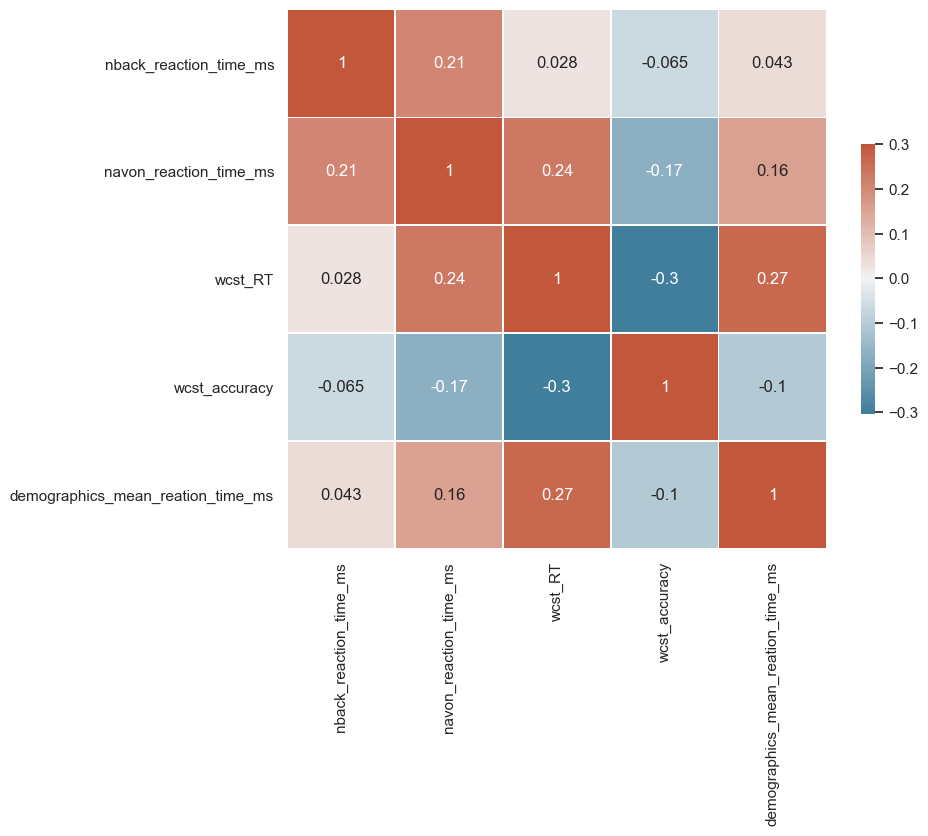

In [98]:
df = spf.ed.summary_table[[
   # ---- wcst
   'wcst_accuracy',

   # ----- RT vars
   'wcst_RT', 'nback_reaction_time_ms', 'navon_reaction_time_ms', 'demographics_mean_reation_time_ms',

   # ----- experiments
   # 'nback_status',  
   # 'fitts_mean_deviation',
   # 'corsi_block_span', 'navon_level_of_target', 'navon_perc_correct',
   #  'nback_group', 'fitts_group', 'corsi_group', 'navon_group',
   #  'wcst_group', 'random_participants'

   # ----- demographics
    #    'demographics_age_a', 'demographics_gender_a',
    #    'demographics_handedness_a', 'demographics_education_a',
    #    'demographics_income_a', 'demographics_computer_hours_a',
    #    'demographics_age_group', 
   ]]

sns.set_theme(style="white")
corrMatrix = df.corr()


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, #mask=mask, 
cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})




plt.show()

In [97]:
# ----- Categorial Correlation: ANOVA -----x

In [52]:
def wcst_performance_plot(
    self, group='corsi_group', 
    mean_plot=False,
    colours=px.colors.sequential.Plasma,
    title='WCST Performance', 
    xaxis={'title':'trials'}, 
    yaxis={'title':'% Correct'}, 
    template='none', 
    legend_title_text='', width=900, height=500, show_vlines=False):

    # ---- fetch data ----x
    summary_data=self.ed.summary_table.copy()
    wcst_performance_data=self.wcst_performance.copy()

    # --- join data + compute performance per group ---x
    x = wcst_performance_data.set_index(('participant',''))
    x = x.loc[x['status']==1,:] #???
    data = x.join(summary_data)

    # # ---- reset column names ----x
    cols = []
    for c in data.columns:
            if type(c) is tuple: cols.append('_'.join(c).strip('_'))
            else: cols.append(c)
    data.columns = cols
    
    def compute_performance_per_group(data, group):
        x = data.groupby([group, 'trials_2']).agg({
            'percentages'           :'mean', 
            'reaction_time_ms_mean' :'mean'
            }).reset_index()
        # x.columns = [xx[0] for xx in x.columns]
        return x
    if not group:
            data['all'] = 'all data' 
            group = 'all'
    data = compute_performance_per_group(data=data, group=group)


    # ---------- plots ----------x
    if not legend_title_text: legend_title_text = group
    groups = data[group].unique()
    traces = []
    c=-1
    for g in groups:
        c+=1
        if g != 'Na' and g != 'other':
            df    = data.loc[(data[group] == g), ['trials_2', 'percentages', 'reaction_time_ms_mean']]
            trace = go.Scatter(x=df.trials_2, y=df.percentages, mode='lines+markers', name='{}'.format(g),
                    line=dict(color='black'), 
                    marker=dict(
                        size=df['reaction_time_ms_mean']/100,
                        color=colours[c],
                        opacity=0.75,
                        line=dict(color='white')))
            traces.append(trace)
    
    if mean_plot:
        df = data.groupby('trials_2').agg({
            'percentages'           :'mean', 
            'reaction_time_ms_mean' :'mean'
            }).reset_index()
        g  = 'aggregate'
        trace = go.Scatter(x=df.trials_2, y=df['percentages'], mode='lines+markers', name='{}'.format(g),
                line=dict(color='black'), 
                marker=dict(
                    size=df['reaction_time_ms_mean']/100,
                    color=colours[-1],
                    opacity=0.75,
                    line=dict(color='white'))
                    )
        traces.append(trace)

    layout  = go.Layout(title=title, xaxis=xaxis, yaxis=yaxis, template=template, legend_title_text=legend_title_text, width=width, height=height)
    fig     = go.Figure(data=traces, layout=layout)

    if show_vlines:
        cum_seq=[10,19,27,35,42,47,53,60,65,70,77,83,88,94,100]
        for c in cum_seq: fig.add_vline(x=c, line_width=0.75, line_dash='dash', line_color='steelblue')
    return {'figure': fig, 'data':data}



In [53]:
wcst = spf.wcst_performance_plot(group='corsi_group', mean_plot=True, show_vlines=True) 
wcst['figure']

AttributeError: 'NoneType' object has no attribute 'copy'

In [29]:
print('dims: ', spf.ed.summary_table.shape)
spf.ed.summary_table.columns

dims:  (824, 22)


Index(['nback_status', 'nback_reaction_time_ms', 'fitts_mean_deviation',
       'corsi_block_span', 'navon_level_of_target', 'navon_perc_correct',
       'navon_reaction_time_ms', 'wcst_RT', 'wcst_accuracy',
       'demographics_age_a', 'demographics_gender_a',
       'demographics_handedness_a', 'demographics_education_a',
       'demographics_income_a', 'demographics_computer_hours_a',
       'demographics_age_group', 'demographics_mean_reation_time_ms',
       'nback_group', 'fitts_group', 'corsi_group', 'navon_group',
       'wcst_group'],
      dtype='object')

# Visualize WCST ~ Covariates 

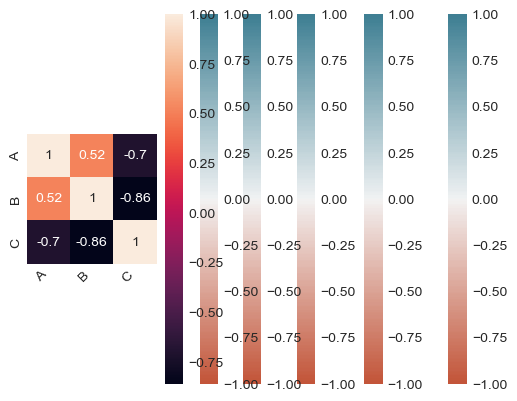

In [25]:

# difference between: ???

# - self.ed.summary_table.copy()
# - wcst_performance_data=self.wcst_performance.copy()

spf.ed.summary_table.head()
spf.wcst_performance